# Visualizing LinkedIn Connections

* AIM: Creating a network that connects me to all the companies from my connections
  * Will visualize it using graph (made up of vertices(nodes/points) which are connected by edges (links/lines))
  * A single node that connects with dozens of other nodes, where the count of the companies correspond with the size of the node.
  * eg: If you connect with tons people working at Amazon, the Amazon will be larger
  * https://miro.medium.com/max/788/1*t-UCEMF6EBDU2ESkeczpdQ.jpeg

## Fuzzy Wuzzy Matching
* Its useful for matching strings like names of people or places, which might be spelled differently with cased different or some other minor changes.
* Fuzzy Wuzzy uses some similarity ratio between two sequences and returns the similarity percentage
* There is a ratio function that calculates the Leveshtein distance similarity ration between two strings
* The Levenshtein distance is a metric to measure how apart are two sequences of words. In other words, it measures the minimum number of edits that you need to do to change a one-word sequence into the other. These edits can be insertions, deletions or substitutions. This metric was named after Vladimir Levenshtein, who originally considered it in 1965.
* Using the partial ratio() function above, we get a similarity ratio of 100. In the scenario of Chicago and Chicago, Illinois this can be helpful since both strings are referring to the same city. This function is also useful when matching names. For example, if one sequence was someone’s first and middle name, and the sequence you’re trying to match on is that person’s first, middle, and last name. The partial_ratio() function will return a 100% match since the person’s first and middle name are the same.
* FuzzyWuzzy also has token functions that tokenize the strings, change capitals to lowercase, and remove punctuation. The token_sort_ratio() function sorts the strings alphabetically and then joins them together. Then, the fuzz.ratio() is calculated. This can come in handy when the strings you are comparing are the same in spelling but are not in the same order.
* The token_set_ratio() function is similar to the token_sort_ratio() function above, except it takes out the common tokens before calculating the fuzz.ratio() between the new strings. This function is the most helpful when applied to a set of strings with a significant difference in lengths.
* FuzzyWuzzy also comes with a handy module, process, that returns the strings along with a similarity score out of a vector of strings.
* Finally, replacing words which are very similar to each other.

In [1]:
# installing janitor 
!pip install pyjanitor pyvis --quiet
!pip install fuzzywuzzy --quiet

* janitor = Clean APIs for data cleaning. It is the python implementation of R package janitor (https://github.com/pyjanitor-devs/pyjanitor)
* NetwworkX = Creates network graph with python (https://networkx.org/)
* Pyvis = Visualizing network graph (https://pyvis.readthedocs.io/en/latest/index.html#)

In [2]:
# loading libraries
import pandas as pd 
import janitor
import datetime
from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx
pd.set_option('max_rows', 99999)
import warnings
warnings.filterwarnings('ignore')
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

* the original file has notes on first two rows, so reading the data from the third line

In [3]:
df = pd.read_csv('Connections.csv', skiprows=2)

In [4]:
df.head()

,First Name,Last Name,Email Address,Company,Position,Connected On
0,Meghana,G,NaN,National Engineering Olympiad,Campus Ambassador,21 Dec 2021
1,Ruma,Panda,NaN,Self-employed,Data Analyst,21 Dec 2021
2,Manish,Kumar,NaN,Doubtbuddy,Data Science Intern,21 Dec 2021
3,Chirantan,Gupta,NaN,Hewlett Packard Enterprise,Data Scientist,21 Dec 2021
4,Prajesh,Sortee,NaN,SmatBot,Jr.Data Scientist,21 Dec 2021


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     525 non-null    object
 1   Last Name      525 non-null    object
 2   Email Address  16 non-null     object
 3   Company        504 non-null    object
 4   Position       505 non-null    object
 5   Connected On   529 non-null    object
dtypes: object(6)
memory usage: 24.9+ KB


## Data Cleaning

In [6]:
connections = (df
      .clean_names() # removing spacing and capitalizations
      .drop(columns = ['first_name', 'last_name', 'email_address']) #dropping for privacy
      .dropna(subset = ['company', 'position']) #dropping missing values
      .to_datetime('connected_on', format='%d %b %Y'))

* Chaining operations = this approach is called functional programming

In [7]:
connections.reset_index(drop=True, inplace=True)

In [8]:
connections.sample()

,company,position,connected_on
341,Quantiphi,Lead Business Analyst,2021-06-29


## Exploratory Data Analysis

### 1. Top 10 companies

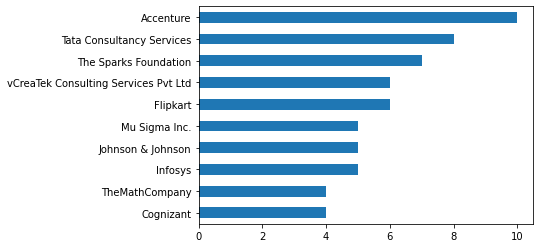

In [9]:
connections['company'].value_counts().head(10).plot(kind='barh').invert_yaxis()

* I follow good number of people from Accenture
* Did not expect that I follow a good number of Self-employed people (basically who are involved in their own business)

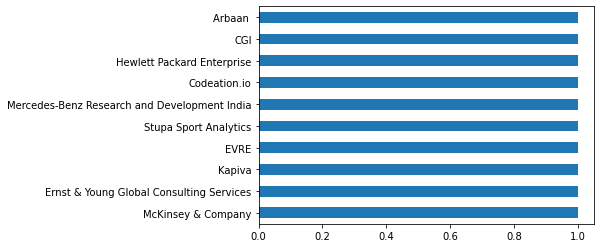

In [10]:
connections['company'].value_counts().tail(10).plot(kind='barh').invert_yaxis()

In [11]:
# connections['company'].value_counts() 

### 2. Top 10 positions

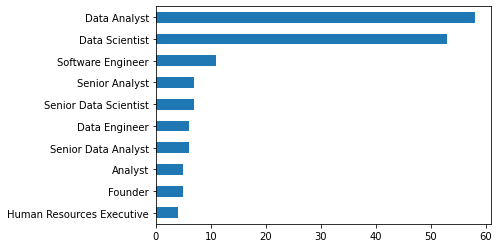

In [12]:
connections['position'].value_counts().head(10).plot(kind='barh').invert_yaxis()

* For positions, the 'Data Scientist' & 'Data Analyst' titles has a huge lead

### 3. Month connected on

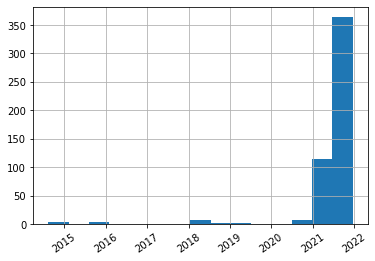

In [13]:
connections['connected_on'].hist(xrot=35, bins=15)

* Have been on LinkedIn since 2015, and it is very obvious that I have not much utlized this app for connections and networking till the year 2021
* In 2021, most connections were made as realized how important is networking and due to this landed my first job in corporate world as Jr. Data Scientist

### 4. Aggregate position and connection column

In [14]:
df_company = connections['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by='count', ascending=False)
df_company.head(10)

,company,count
0,Accenture,10
1,Tata Consultancy Services,8
2,The Sparks Foundation,7
4,Flipkart,6
3,vCreaTek Consulting Services Pvt Ltd,6
5,Mu Sigma Inc.,5
6,Johnson & Johnson,5
7,Infosys,5
8,TheMathCompany,4
9,Cognizant,4


### 5. Creating the network

#### a. Company Graph

In [15]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=2]
print(df_company_reduced.shape)

(402, 2)
(46, 2)


* First, initializing the graph, adding the root node which is me
* Then iterating over rows and in eacc for loop, saving the company name and count for later use
* To display info of positions on each node that our connections hold at those companies, using list comphrehension to grab the positions and storing them in a set
* For hover info on the nodes prettier, using HTML to format the information
* At the end of each loop, we add the new node, and then add the link to our root node
* After the graph is built, we add it to network to display the graph

In [16]:
# initialize graph
g = nx.Graph()
# initializing myself as central
g.add_node('root')

# using iterrows to iterate through the dataframe
for _, row in df_company_reduced.iterrows():
  # storing company name and count
  company = row['company']
  count = row['count']

  title = f'<b>{company}</b> - {count}'
  positions = set([x for x in connections[company == connections['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f'<ul>{positions}</ul>'
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

In [17]:
# generating the graph
nt = net.Network(height='700px', width='700px', bgcolor='black', font_color='white')
nt.from_nx(g)
nt.hrepulsion()

# more customization at https://tinyurl.com/yf51vvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [18]:
list_1 = connections['company'].tolist()
list_2 = connections['company'].tolist()
# converting to pandas dataframes
dframe1 = pd.DataFrame(list_1)
dframe2 = pd.DataFrame(list_2)
dframe1 = dframe1.rename_column(0, 'name')
dframe2 = dframe2.rename_column(0, 'name')
# print(dframe1)
# empty lists for storing the matches
# later
mat1 = []
mat2 = []
p = []
  
# converting dataframe column 
# to list of elements
# to do fuzzy matching
list1 = dframe1['name'].tolist()
list2 = dframe2['name'].tolist()
  
# taking the threshold as 50
threshold = 70
  
# iterating through list1 to extract
# it's closest match from list2
for i in list1:
    mat1.append(process.extractOne(
      i, list2, scorer=fuzz.token_set_ratio))
dframe1['matches'] = mat1
  
# iterating through the closest matches
# to filter out the maximum closest match
for j in dframe1['matches']:
    if j[1] >= threshold:
        p.append(j[0])
    mat2.append(",".join(p))
    p = []
  
  
# storing the resultant matches back 
# to dframe1
dframe1['matches'] = mat2
connections['company_1'] = None
for i in range(len(connections)):
  connections['company_1'][i] = dframe1['matches'][i]
connections.head()

,company,position,connected_on,company_1
0,National Engineering Olympiad,Campus Ambassador,2021-12-21,National Engineering Olympiad
1,Self-employed,Data Analyst,2021-12-21,Self-employed
2,Doubtbuddy,Data Science Intern,2021-12-21,Doubtbuddy
3,Hewlett Packard Enterprise,Data Scientist,2021-12-21,Hewlett Packard Enterprise
4,SmatBot,Jr.Data Scientist,2021-12-21,SmatBot


In [19]:
df_company = connections['company_1'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by='count', ascending=False)
df_company.head(10)

print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=2]
print(df_company_reduced.shape)

# initialize graph
g = nx.Graph()
# initializing myself as central
g.add_node('root')

# using iterrows to iterate through the dataframe
for _, row in df_company_reduced.iterrows():
  # storing company name and count
  company = row['company']
  count = row['count']

  title = f'<b>{company}</b> - {count}'
  positions = set([x for x in connections[company == connections['company']]['position']])
  positions = ''.join('<li>{}</li>'.format(x) for x in positions)

  position_list = f'<ul>{positions}</ul>'
  hover_info = title + position_list

  g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
  g.add_edge('root', company, color='grey')

# generating the graph
nt = net.Network(height='700px', width='700px', bgcolor='black', font_color='white')
nt.from_nx(g)
nt.hrepulsion()

# more customization at https://tinyurl.com/yf51vvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

(375, 2)
(46, 2)


#### b. Position Graph

In [20]:
df_position = connections['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by='count', ascending=False)
df_position.head(10)

,position,count
0,Data Analyst,58
1,Data Scientist,53
2,Software Engineer,11
3,Senior Analyst,7
4,Senior Data Scientist,7
5,Data Engineer,6
6,Senior Data Analyst,6
7,Analyst,5
8,Founder,5
9,Human Resources Executive,4


In [21]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=2]
print(df_position_reduced.shape)

(308, 2)
(42, 2)


In [22]:
g = nx.Graph()
g.add_node('root')

for _, row in df_position_reduced.iterrows():
  positions = row['position']
  count = row['count']

  title = f"<b>{positions}</b> - {count}"
  hover_info = title

  # count = f"{row['count']}"
  # positions = row['position_2']
  g.add_node(positions, size=count, color='yellow', title=hover_info)
  g.add_edge('root', positions, color='grey')

In [23]:
nt = net.Network(height='700px', width='700px', bgcolor='black', font_color='white')
nt.from_nx(g)
nt.hrepulsion()
nt.show('position_graph.html')
display(HTML('position_graph.html'))

#### Matching position names

In [24]:
list_1 = connections['position'].tolist()
list_2 = connections['position'].tolist()

In [25]:
print(list_1)

['Campus Ambassador', 'Data Analyst', 'Data Science Intern', 'Data Scientist', 'Jr.Data Scientist', 'Associate Data Scientist', 'Data Scientist', 'Software Engineer Sr. Analyst', 'Machine Learning Intern', 'Jr. Data Scientist', 'Human Resources Consultant', 'Data Science & Business Analyst Intern', 'Data Scientist', 'Data Analyst', 'Data Science', 'Data Scientist', 'Content Creation Associate', 'Software Developer', 'System Engineer', 'Data Scientist', 'Data Scientist', 'Assistant System Engineer ', 'Manager - HR', 'Executive Director', 'Sr Data scientist', 'Sr. Data Scientist ', 'Bimoterics Administrator', 'Data Science', 'Python Developer', 'Data Analyst', 'EMC Hardware engineer ', 'Jr.Executive - Client Relations ', 'Assistant System Engineer', 'Data Scientist', 'Senior Data Engineer', 'Programming Analyst', 'Data Analyst', 'Major Vocational Training', 'Data Scientist Intern', 'Co-Founder', 'Machine Learning Engineer', 'Consulting Analyst', 'Project Lead', 'Chief Executive Officer',

In [26]:
# converting to pandas dataframes
dframe1 = pd.DataFrame(list_1)
dframe2 = pd.DataFrame(list_2)
dframe1 = dframe1.rename_column(0, 'name')
dframe2 = dframe2.rename_column(0, 'name')
# print(dframe1)

In [27]:
# empty lists for storing the matches
# later
mat1 = []
mat2 = []
p = []
  
# converting dataframe column 
# to list of elements
# to do fuzzy matching
list1 = dframe1['name'].tolist()
list2 = dframe2['name'].tolist()
  
# taking the threshold as 50
threshold = 70
  
# iterating through list1 to extract
# it's closest match from list2
for i in list1:
    mat1.append(process.extractOne(
      i, list2, scorer=fuzz.token_set_ratio))
dframe1['matches'] = mat1
  
# iterating through the closest matches
# to filter out the maximum closest match
for j in dframe1['matches']:
    if j[1] >= threshold:
        p.append(j[0])
    mat2.append(",".join(p))
    p = []
  
  
# storing the resultant matches back 
# to dframe1
dframe1['matches'] = mat2
print("\nDataFrame after Fuzzy matching using token_set_ratio():")
dframe1


DataFrame after Fuzzy matching using token_set_ratio():


,name,matches
0,Campus Ambassador,Campus Ambassador
1,Data Analyst,Data Analyst
2,Data Science Intern,Data Science Intern
3,Data Scientist,Data Scientist
4,Jr.Data Scientist,Data Scientist
5,Associate Data Scientist,Data Scientist
6,Data Scientist,Data Scientist
7,Software Engineer Sr. Analyst,Software Engineer Sr. Analyst
8,Machine Learning Intern,Machine Learning Intern
9,Jr. Data Scientist,Data Scientist


In [28]:
connections['position_2'] = None
for i in range(len(connections)):
  connections['position_2'][i] = dframe1['matches'][i]
connections.head()

,company,position,connected_on,company_1,position_2
0,National Engineering Olympiad,Campus Ambassador,2021-12-21,National Engineering Olympiad,Campus Ambassador
1,Self-employed,Data Analyst,2021-12-21,Self-employed,Data Analyst
2,Doubtbuddy,Data Science Intern,2021-12-21,Doubtbuddy,Data Science Intern
3,Hewlett Packard Enterprise,Data Scientist,2021-12-21,Hewlett Packard Enterprise,Data Scientist
4,SmatBot,Jr.Data Scientist,2021-12-21,SmatBot,Data Scientist


In [29]:
df_position = connections['position_2'].value_counts().reset_index()
df_position.columns = ['position_2', 'count']
df_position = df_position.sort_values(by='count', ascending=False)
df_position.head(10)
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=3]
print(df_position_reduced.shape)
g = nx.Graph()
g.add_node('root')

for _, row in df_position_reduced.iterrows():
  positions = row['position_2']
  count = row['count']

  title = f"<b>{positions}</b> - {count}"
  hover_info = title

  # count = f"{row['count']}"
  # positions = row['position_2']
  g.add_node(positions, size=count, color='green', title=hover_info)
  g.add_edge('root', positions, color='grey')

nt = net.Network(height='700px', width='700px', bgcolor='black', font_color='white')
nt.from_nx(g)
nt.hrepulsion()
nt.show('position_graph.html')
display(HTML('position_graph.html'))

(158, 2)
(34, 2)


* Further narrowing it down using for loop by matching certain keywords with their respective fields

In [30]:
# connections['position_2'].value_counts()

* Going one step further for matching similar position names using for loop as shown below.

In [31]:
connections['position_3'] = None
for i in range(len(connections)):
  if 'data scientist' in connections['position_2'][i].lower():
    connections['position_3'][i] = 'Data Scientist'
  elif 'Data Science' in connections['position_2'][i]:
    connections['position_3'][i] = 'Data Scientist'
  elif 'Data Engineer' in connections['position_2'][i]:
    connections['position_3'][i] = 'Data Engineer' 
  elif 'Talent' in connections['position_2'][i]:
    connections['position_3'][i] = 'Talent Acquisition' 
  elif 'HR' in connections['position_2'][i]:
    connections['position_3'][i] = 'HR'
  elif 'Human Resources' in connections['position_2'][i]:
    connections['position_3'][i] = 'HR'
  elif 'Software Engineer' in connections['position_2'][i]:
    connections['position_3'][i] = 'Software Engineer'
  elif 'Manager' in connections['position_2'][i]:
    connections['position_3'][i] = 'Manager'
  elif 'manager' in connections['position_2'][i]:
    connections['position_3'][i] = 'Manager'
  elif 'Recruitment' in connections['position_2'][i]:
    connections['position_3'][i] = 'Recruitment'
  elif 'Recruiter' in connections['position_2'][i]:
    connections['position_3'][i] = 'Recruitment'
  elif 'Developer' in connections['position_2'][i]:
    connections['position_3'][i] = 'Developers'
  elif 'Project Leader' in connections['position_2'][i]:
    connections['position_3'][i] = 'Team Lead'
  elif 'Consultant' in connections['position_2'][i]:
    connections['position_3'][i] = 'Consultant'
  else:
    connections['position_3'][i] = connections['position_2'][i]

In [32]:
connections.head()

,company,position,connected_on,company_1,position_2,position_3
0,National Engineering Olympiad,Campus Ambassador,2021-12-21,National Engineering Olympiad,Campus Ambassador,Campus Ambassador
1,Self-employed,Data Analyst,2021-12-21,Self-employed,Data Analyst,Data Analyst
2,Doubtbuddy,Data Science Intern,2021-12-21,Doubtbuddy,Data Science Intern,Data Scientist
3,Hewlett Packard Enterprise,Data Scientist,2021-12-21,Hewlett Packard Enterprise,Data Scientist,Data Scientist
4,SmatBot,Jr.Data Scientist,2021-12-21,SmatBot,Data Scientist,Data Scientist


In [33]:
# connections['position_3'].value_counts()

In [34]:
df_position = connections['position_3'].value_counts().reset_index()
df_position.columns = ['position_3', 'count']
df_position = df_position.sort_values(by='count', ascending=False)
df_position.head(10)
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=2]
print(df_position_reduced.shape)
g = nx.Graph()
g.add_node('root')

for _, row in df_position_reduced.iterrows():
  positions = row['position_3']
  count = row['count']

  title = f"<b>{positions}</b> - {count}"
  hover_info = title

  # count = f"{row['count']}"
  # positions = row['position_2']
  g.add_node(positions, size=count, color='gray', title=hover_info)
  g.add_edge('root', positions, color='grey')

nt = net.Network(height='800px', width='800px', bgcolor='black', font_color='white')
nt.from_nx(g)
nt.hrepulsion()
nt.show('position_graph.html')
display(HTML('position_graph.html'))

(98, 2)
(30, 2)


In [35]:
list_1 = connections['position_3'].tolist()
list_2 = connections['position_3'].tolist()
# converting to pandas dataframes
dframe1 = pd.DataFrame(list_1)
dframe2 = pd.DataFrame(list_2)
dframe1 = dframe1.rename_column(0, 'name')
dframe2 = dframe2.rename_column(0, 'name')
# print(dframe1)
# empty lists for storing the matches
# later
mat1 = []
mat2 = []
p = []
  
# converting dataframe column 
# to list of elements
# to do fuzzy matching
list1 = dframe1['name'].tolist()
list2 = dframe2['name'].tolist()
  
# taking the threshold as 50
threshold = 70
  
# iterating through list1 to extract
# it's closest match from list2
for i in list1:
    mat1.append(process.extractOne(
      i, list2, scorer=fuzz.token_set_ratio))
dframe1['matches'] = mat1
  
# iterating through the closest matches
# to filter out the maximum closest match
for j in dframe1['matches']:
    if j[1] >= threshold:
        p.append(j[0])
    mat2.append(",".join(p))
    p = []
  
  
# storing the resultant matches back 
# to dframe1
dframe1['matches'] = mat2
connections['position_4'] = None
for i in range(len(connections)):
  connections['position_4'][i] = dframe1['matches'][i]
connections.head()

,company,position,connected_on,company_1,position_2,position_3,position_4
0,National Engineering Olympiad,Campus Ambassador,2021-12-21,National Engineering Olympiad,Campus Ambassador,Campus Ambassador,Campus Ambassador
1,Self-employed,Data Analyst,2021-12-21,Self-employed,Data Analyst,Data Analyst,Data Analyst
2,Doubtbuddy,Data Science Intern,2021-12-21,Doubtbuddy,Data Science Intern,Data Scientist,Data Scientist
3,Hewlett Packard Enterprise,Data Scientist,2021-12-21,Hewlett Packard Enterprise,Data Scientist,Data Scientist,Data Scientist
4,SmatBot,Jr.Data Scientist,2021-12-21,SmatBot,Data Scientist,Data Scientist,Data Scientist


In [37]:
connections.sample(10)

,company,position,connected_on,company_1,position_2,position_3,position_4
212,Wipro Limited,Project Engineer,2021-07-23,Wipro,Engineer,Engineer,Software Engineer
467,Fedo.ai,Data Science and Analytics,2021-05-17,Fedo.ai,Data Science,Data Scientist,Data Scientist
309,HiyaMee,Customer Success Manager,2021-07-06,HiyaMee,Senior customer success manager (Technical acc...,Manager,Manager
183,adqvest capital,Data Analyst,2021-08-02,adqvest capital,Data Analyst,Data Analyst,Data Analyst
83,Mu Sigma Inc.,Data Scientist,2021-10-04,Mu Sigma Inc.,Data Scientist,Data Scientist,Data Scientist
390,Infosys,Data Scientist,2021-06-21,Infosys Ltd,Data Scientist,Data Scientist,Data Scientist
57,Mu Sigma Inc.,Lead Data Scientist ( Trainee Decision Scienti...,2021-12-07,Mu Sigma Inc.,Data Scientist,Data Scientist,Data Scientist
445,Drishti IAS,Teaching Faculty,2021-06-07,Drishti IAS,Teaching Faculty,Teaching Faculty,Teaching Faculty
230,Shell,Data Science CoE - Shell.ai Manager,2021-07-19,Shell,Data Science,Data Scientist,Data Scientist
207,DecisionTree Analytics & Services,Data Analyst,2021-07-26,DecisionTree Analytics & Services,Data Analyst,Data Analyst,Data Analyst


In [36]:
df_position = connections['position_4'].value_counts().reset_index()
df_position.columns = ['position_4', 'count']
df_position = df_position.sort_values(by='count', ascending=False)
df_position.head(10)
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=2]
print(df_position_reduced.shape)
g = nx.Graph()
g.add_node('root', color='white')

for _, row in df_position_reduced.iterrows():
  positions = row['position_4']
  count = row['count']

  title = f"<b>{positions}</b> - {count}"
  hover_info = title

  # count = f"{row['count']}"
  # positions = row['position_2']
  g.add_node(positions, size=count, color='orange', title=hover_info)
  g.add_edge('root', positions, color='grey')

nt = net.Network(height='800px', width='1000px', bgcolor='black', font_color='white')
nt.from_nx(g)
nt.hrepulsion()
nt.show('position_graph.html')
display(HTML('position_graph.html'))

(92, 2)
(27, 2)
